# Loading data

In [ ]:
! wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
! unzip ml-1m.zip -d .

In [1]:
import pandas as pd
import numpy as np
import tensorflow

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ratings = (pd.read_csv('./ml-1m/ratings.dat', engine='python', sep='::', names=['user', 'item', 'rating', 'timestamp'])
    .assign(timestamp=lambda df:pd.to_datetime(df.timestamp * 1000000000))
          )

movies = (pd.read_csv('./ml-1m/movies.dat', engine='python', sep='::', names=['item', 'title', 'genres'])
          .assign(genres=lambda df:df.genres.str.split('|').values)
          .set_index('item', drop=False))

# See http://files.grouplens.org/datasets/movielens/ml-1m-README.txt for more details
users = pd.read_csv('./ml-1m/users.dat', engine='python', sep='::', 
                    names=['user', 'gender', 'age', 'occupation', 'zipcode'])\
    .set_index('user', drop=False)

In [3]:
ratings = ratings.assign(feedback=lambda df: 2 * (df.rating >= 4) - 1)

ratings.head()

,user,item,rating,timestamp,feedback
0,1,1193,5,2000-12-31 22:12:40,1
1,1,661,3,2000-12-31 22:35:09,-1
2,1,914,3,2000-12-31 22:32:48,-1
3,1,3408,4,2000-12-31 22:04:35,1
4,1,2355,5,2001-01-06 23:38:11,1


## Train/test split

 * Ideally time based split
 * For the sake of simplicity, let's just sample ratings uniformly (breaking the time machine rule)

In [4]:
test = ratings.sample(n=100000, random_state=0)
train_ratings_mask = ~ratings.index.isin(test.index)
train = ratings.loc[train_ratings_mask]

test_user_items = test[['user', 'item']]

print(train.shape)
print(test.shape)

test.head()

(900209, 5)
(100000, 5)


,user,item,rating,timestamp,feedback
324271,1922,2094,4,2000-11-20 04:34:27,1
818637,4918,2808,1,2000-07-08 19:29:05,-1
148677,957,1660,4,2000-11-25 05:28:13,1
778790,4653,914,5,2000-11-29 21:22:43,1
525489,3245,3324,1,2000-09-07 06:33:31,-1


## Refresher on cross entropy loss

In [5]:
import tensorflow as tf
sess = tf.InteractiveSession()

For the binary case, $\hat{p}$

$$ LL(y, \hat{p}) = - \log p \text{ if $y = 1$ and } - log(1 - p) \text{ if $y = 0$}
$$

For the $K$ multi-classes case, $\hat{\mathbf{p}}$ is a vector

$$ LL(y, \mathbf{p}) = - \log \mathbf{p}_y
$$


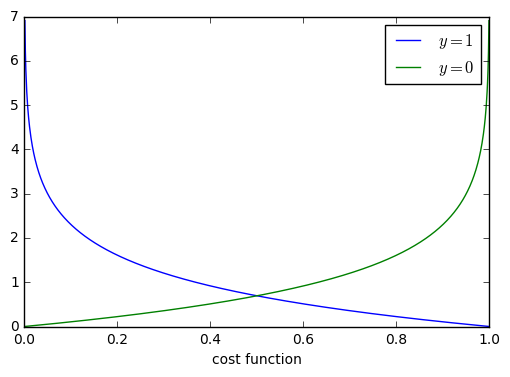

In [6]:
grid_ps = np.linspace(0, 1, num=1000)[1:-1]
plt.plot(grid_ps, -np.log(grid_ps), label='$y = 1$')
plt.plot(grid_ps, -np.log(1 - grid_ps), label='$y = 0$')
plt.legend(); plt.xlabel('p[x]'); plt.xlabel('cost function');

In [7]:
BATCH_SIZE = 4
N_CLASSES = 3

logits_values = np.array([[10, 1, 1], [10, 1, 1], [1, 2, 1], [1, 2, 1]], dtype=float)
logits = tf.constant(logits_values, shape=(BATCH_SIZE, N_CLASSES))

logits.eval()

array([[ 10.,   1.,   1.],
       [ 10.,   1.,   1.],
       [  1.,   2.,   1.],
       [  1.,   2.,   1.]])

In [11]:
labels_values = np.array([0, 1, 1, 2])
labels = tf.constant(labels_values)

one_hot_values = np.array([[1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float)
one_hot_labels = tf.constant(one_hot_values)

print('class labels:')
print(tf.reshape(labels, (-1, 1)).eval())

print('one-hot encoded class labels:')
print(one_hot_labels.eval())

class labels:
[[0]
 [1]
 [1]
 [2]]
one-hot encoded class labels:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


In [12]:
# tf.nn.sparse_softmax_cross_entropy_with_logits (a la word2vec)
# Measures the probability error in discrete classification tasks in which the
# classes are mutually exclusive (each entry is in exactly one class).

loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels)
loss.eval()

array([  2.46789153e-04,   9.00024679e+00,   5.51444714e-01,
         1.55144471e+00])

In [13]:
# step by step numpy equivalent
raw_softmax_values = np.exp(logits_values)
probabilities = (raw_softmax_values.T / np.sum(raw_softmax_values, axis=1)).T
probabilities

array([[  9.99753241e-01,   1.23379352e-04,   1.23379352e-04],
       [  9.99753241e-01,   1.23379352e-04,   1.23379352e-04],
       [  2.11941558e-01,   5.76116885e-01,   2.11941558e-01],
       [  2.11941558e-01,   5.76116885e-01,   2.11941558e-01]])

In [15]:
cross_entropy_losses = -np.log(probabilities)[[0, 1, 2, 3], label_values]
cross_entropy_losses

array([  2.46789153e-04,   9.00024679e+00,   5.51444714e-01,
         1.55144471e+00])

In [16]:
# tf.nn.sigmoid_cross_entropy_with_logits (like in the CF auto-encoder article)
# Measures the probability error in discrete classification tasks in which each
# class is independent and not mutually exclusive.
tf.nn.sigmoid_cross_entropy_with_logits(logits, targets=one_hot_labels).eval()

array([[  4.53988992e-05,   1.31326169e+00,   1.31326169e+00],
       [  1.00000454e+01,   3.13261688e-01,   1.31326169e+00],
       [  1.31326169e+00,   1.26928011e-01,   1.31326169e+00],
       [  1.31326169e+00,   2.12692801e+00,   3.13261688e-01]])

## TensorFlow multi-class classification

http://stackoverflow.com/questions/37671974/tensorflow-negative-sampling

Can use:
 * `sparse_softmax_cross_entropy_with_logits` or `tf.nn.sampled_softmax_loss` (multi-class classsification a la word2vec)
 * but we could try [`tf.nn.sigmoid_cross_entropy_with_logits`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#sigmoid_cross_entropy_with_logits) like in [Collaborative Denoising Auto-Encoders for Top-N Recommender Systems](http://yaowu.co/docs/wsdm16cdae.pdf)
 
Evaluating on a topn metric

In [17]:
def recall_at_k(logits_values, test, topk = 5):
    user_item_predicted_ranks = np.argsort(np.argsort(-logits_values, axis=1)) + 1
    user_item_topk_predictions = set(zip(*np.where(user_item_predicted_ranks <= topk)))
    test_ground_truths = set(zip(test[test.feedback > 0].user.values, test[test.feedback > 0].item.values))
    return len(test_ground_truths.intersection(user_item_topk_predictions)) / len(test_ground_truths)

In [18]:
import tensorflow as tf

import datetime as dt

BATCH_SIZE = 1024
N_ITER = 100
LOG_DIR = '/tmp/tflearn_logs'

N_ITEMS = ratings.item.max() + 1
N_USERS = ratings.user.max() + 1

N_USERS, N_ITEMS

(6041, 3953)

In [20]:
class UserAndItem2Vec:
    def __init__(self, dimensionality=50, batch_size=None):
        
        with tf.name_scope('user_embeddings'):
            user_embeddings = tf.Variable(tf.random_normal([N_USERS, dimensionality], 
                                                           stddev=0.01, mean=0), name='users')
            tf.histogram_summary('user_embeddings', user_embeddings)

        with tf.name_scope('item_biases'):
            item_biases = tf.Variable(tf.random_normal([N_ITEMS], stddev=0.01, mean=0), name='items')

        with tf.name_scope('item_embeddings'):
            item_embeddings = tf.Variable(tf.random_normal([N_ITEMS, dimensionality], stddev=0.01, mean=0), name='items')
            tf.histogram_summary('item_embeddings', item_embeddings)

        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings
        self.item_biases = item_biases
    
        self.input_user_ids = tf.placeholder(
            tf.int32, shape=[batch_size], name='user_ids')
        self.input_positive_item_ids = tf.placeholder(
            tf.int32, shape=[batch_size], name='positive_item_ids')

    def user_to_all_item_logits(self):
        """ This is the model described at equation (22) from http://yaowu.co/docs/wsdm16cdae.pdf
        y_ui = \sigma{W_i^t V_u + b_i}
        The architecture is made of:
         * input nodes for the user_id, and associated weights or embeddings V_u
         * internal weights W_i and biases b_i for each items
        """
        return tf.add(
            self.item_biases, 
            tf.matmul(
                tf.nn.embedding_lookup(self.user_embeddings, self.input_user_ids),
                tf.transpose(self.item_embeddings)),
            name='user_to_all_item_logits')

    def sampled_loss(self):
        with tf.name_scope('loss'):
            sample_losses = tf.nn.sampled_softmax_loss(
                biases=self.item_biases,
                inputs=tf.nn.embedding_lookup(self.user_embeddings, self.input_user_ids),
                labels=tf.reshape(self.input_positive_item_ids, (-1, 1)),
                weights=self.item_embeddings,
                num_classes=N_ITEMS,
                num_sampled=10, num_true=1)
            return tf.reduce_mean(sample_losses)
        
    def exact_loss(self):
        with tf.name_scope('loss'):
            cross_entropy_sum = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.user_to_all_item_logits(),
                    labels=self.input_positive_item_ids))
            
        return cross_entropy_sum

def training(loss, learning_rate=0.01):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return train_step

with tf.Graph().as_default():
    model = UserAndItem2Vec()
    loss = model.exact_loss()    #.sampled_loss()
    
    tf.scalar_summary('batch_ll', loss)
    summary = tf.merge_all_summaries()
    test_summary = tf.scalar_summary('test_ll', loss)
    train_step = training(loss)
    
    def perform_step(step, train, test, summary_writer):
        positive_sample_ratings = train.query('feedback == 1').sample(BATCH_SIZE)
        _, loss_value, summary_value = sess.run(
            fetches=[train_step, loss, summary], 
            feed_dict={
                model.input_user_ids: positive_sample_ratings.user.values,
                model.input_positive_item_ids: positive_sample_ratings.item.values
            })
        summary_writer.add_summary(summary_value, global_step=step)

        if step % 10 == 0:
            test_loss_value, test_summary_value = sess.run(
                fetches=[loss, test_summary],
                feed_dict={
                    model.input_user_ids: test.query('feedback == 1').user.values,
                    model.input_positive_item_ids: test.query('feedback == 1').item.values
                })

            all_users_item_logits = model.user_to_all_item_logits().eval(
                feed_dict={model.input_user_ids: np.arange(N_USERS)})

            print('Step {:2d}: batch/test cross-entropy loss = {:.2f}/{:.2f}'.format(step, loss_value, test_loss_value))
            print('         batch/test recall@5 = {:.4f}/{:.4f}'.format(
                    recall_at_k(all_users_item_logits, train, topk=5), 
                    recall_at_k(all_users_item_logits, test, topk=5)))
            summary_writer.add_summary(test_summary_value, global_step=step)

        summary_writer.flush()
        
    with tf.Session() as sess:

        summary_writer = tf.train.SummaryWriter(LOG_DIR + '/{:%Y%m%d%H%M%S}'.format(dt.datetime.now()), sess.graph)

        sess.run(tf.initialize_all_variables())
        
        for step in range(N_ITER):
            perform_step(step, train, test, summary_writer)

Step  0: batch/test cross-entropy loss = 8.28/8.27
         batch/test recall@5 = 0.0026/0.0026
Step 10: batch/test cross-entropy loss = 8.19/8.18
         batch/test recall@5 = 0.0152/0.0117
Step 20: batch/test cross-entropy loss = 8.02/7.99
         batch/test recall@5 = 0.0182/0.0149
Step 30: batch/test cross-entropy loss = 7.70/7.67
         batch/test recall@5 = 0.0201/0.0178
Step 40: batch/test cross-entropy loss = 7.44/7.43
         batch/test recall@5 = 0.0207/0.0189
Step 50: batch/test cross-entropy loss = 7.32/7.37
         batch/test recall@5 = 0.0213/0.0196
Step 60: batch/test cross-entropy loss = 7.31/7.34
         batch/test recall@5 = 0.0211/0.0201
Step 70: batch/test cross-entropy loss = 7.26/7.31
         batch/test recall@5 = 0.0206/0.0198
Step 80: batch/test cross-entropy loss = 7.32/7.30
         batch/test recall@5 = 0.0200/0.0183
Step 90: batch/test cross-entropy loss = 7.24/7.29
         batch/test recall@5 = 0.0199/0.0184
